# Introduction

In this notebook, I build a machine learning model using python which predicts whether a customer will churn (leave the company) or not. Several classification models have been trained and compared. Then, two best performing models - Random Forest Classifier and XGB Classifier have been fine-tuned using GridSearchCV. 

The bussiness logic of the use case have been kept in mind throughout the project i.e. the idea is that we have to focus on customer retention. Therefore, along with the accuracy score huge consederation is given to the recall score to minimize false negatives predictions. 

**Dataset:** [Telco customer churn: IBM dataset](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset) 

**Steps**
1. **EDA** using pandas and effective visualisation.
2. **Feature Selection** by checking impact of each variable on the target variable.
3. Target impbalance variable has been treated using **upsampling** technique to avoid data loss.
4. Numeric variable have been scaled and catagorical ones are enocoded using a **preprocessing pipeline.**
5. Compared 8 classification model and fine-tuned the selected optimum models using **GridSearchCV** 
6. The fine-tuned Random Forest model achieves an **accuracy score** of 95% and **recall score** of 98%, respectively

**Column Description:**

[Please head here](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset), as describing all columns here makes the introduction too long and there is a high chance that you will skip it anyway :)

### Importing the libraries 

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# ensemble models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [130]:
# Load the data
cwd = os.getcwd()
churn_df = pd.read_csv(f'{cwd}/churn_df.csv')

In [131]:
churn_df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


# 1. EDA & Feature Selection

### 1.1. Basic EDA

In [132]:
# Shape of the dataset
churn_df.shape

(7043, 33)

In [133]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

**We do not need the "Churn reason" col to do a predictive analysis. Also, "Churn Value" and "Churn Label" are the same except for their data type, i.e; (0 or 1) and (Yes or No).**

In [134]:
#Drop Churn Reason and Churn Label cols
churn_df.drop("Churn Reason", inplace = True, axis = 1)
churn_df.drop("Churn Label", inplace = True, axis = 1)

In [135]:
# Lets explore our target variable "Churn Label"
churn_df['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Churn Value')

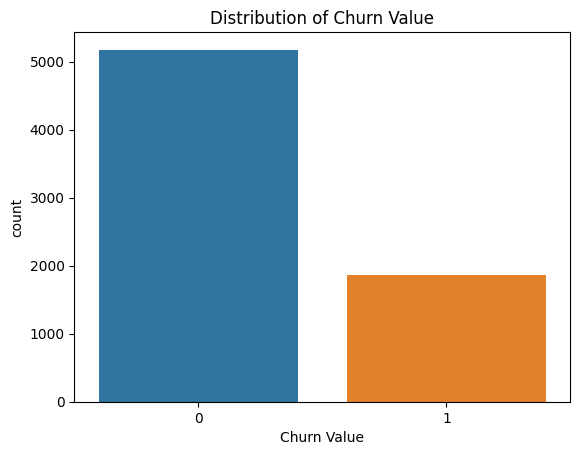

In [136]:
sns.countplot(x = "Churn Value", data = churn_df)
plt.title("Distribution of Churn Value")

**We have a significant imbalance in the datset, but before we treat the imbalance lets explore our explantory variables.**

Lets look into the catagorical cols first:

In [137]:
# Create list of catagorical cols
cat_cols = [col for col in churn_df.columns if churn_df[col].dtype == 'object']

print("We have {} catagorical columns:".format(len(cat_cols)))
cat_cols

We have 22 catagorical columns:


['CustomerID',
 'Country',
 'State',
 'City',
 'Lat Long',
 'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Total Charges']

### 1.2. Lets find out the number of binary cols

In [138]:
# Lets find out the number of binary variables
binary_cols = [col for col in churn_df.columns if churn_df[col].value_counts().shape[0]==2]

print("We have {} binary columns:".format(len(binary_cols)))
binary_cols

We have 7 binary columns:


['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Paperless Billing',
 'Churn Value']

### 1.3. Examine distribution of binary variables

<Axes: xlabel='Phone Service', ylabel='count'>

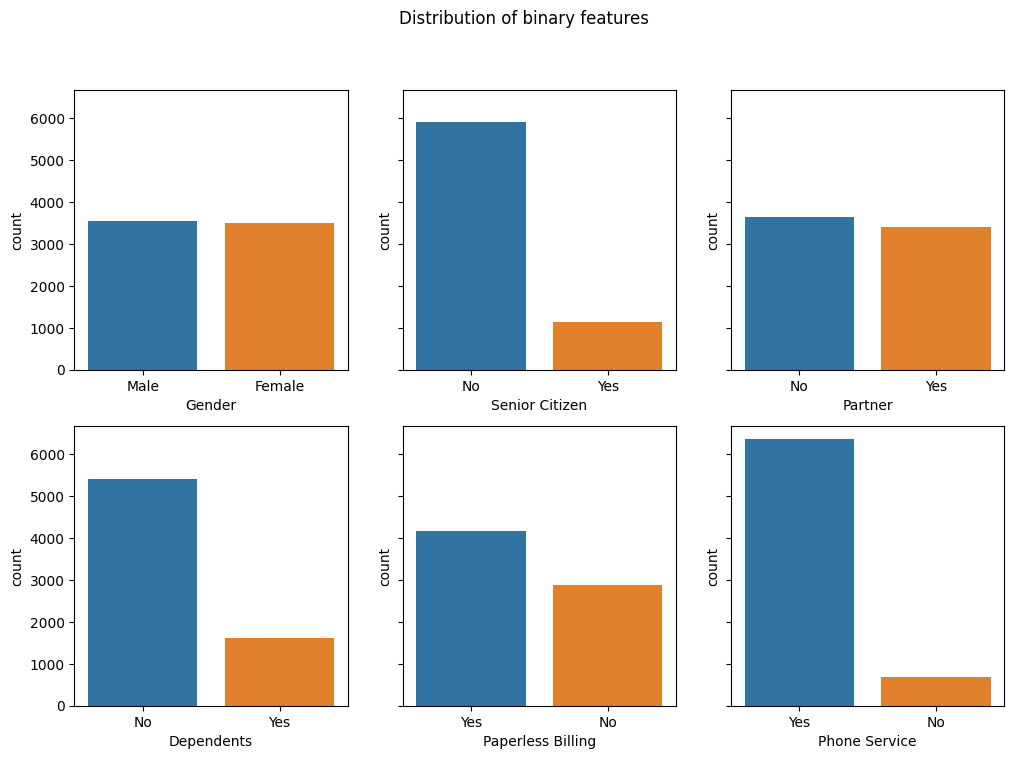

In [139]:
fig, axes = plt.subplots(2,3, figsize = (12,8), sharey = True)
plt.suptitle("Distribution of binary features")
sns.countplot(x = "Gender", data = churn_df, ax=axes[0,0])
sns.countplot(x = "Senior Citizen", data = churn_df, ax=axes[0,1])
sns.countplot(x = "Partner", data = churn_df, ax=axes[0,2])
sns.countplot(x = "Dependents", data = churn_df, ax=axes[1,0])
sns.countplot(x = "Paperless Billing", data = churn_df, ax=axes[1,1])
sns.countplot(x = "Phone Service", data = churn_df, ax=axes[1,2])

#### We can observe high imbalance in:

* Senior Citizen - Most of the customers are below the age of 65 years
* Dependents - Majority do not live with any dependent (kids, parents etc) 
* Phone Service - Most use phone service

### 1.4. Imapct of binary variables on average churn rate

In [140]:
churn_df[['Gender', 'Churn Value']].groupby(['Gender']).mean()

,Churn Value
Gender,
Female,0.269209
Male,0.261603


In [141]:
churn_df[['Senior Citizen', 'Churn Value']].groupby('Senior Citizen').mean()

,Churn Value
Senior Citizen,
No,0.236062
Yes,0.416813


In [142]:
churn_df[['Partner', 'Churn Value']].groupby('Partner').mean()

,Churn Value
Partner,
No,0.329580
Yes,0.196649


In [143]:
churn_df[['Dependents', 'Churn Value']].groupby('Dependents').mean()

,Churn Value
Dependents,
No,0.325517
Yes,0.065151


In [144]:
churn_df[['Phone Service', 'Churn Value']].groupby('Phone Service').mean()

,Churn Value
Phone Service,
No,0.249267
Yes,0.267096


In [145]:
churn_df[['Paperless Billing', 'Churn Value']].groupby('Paperless Billing').mean()

,Churn Value
Paperless Billing,
No,0.163301
Yes,0.335651


### 1.5. Explore non-binary catagorical variables

In [146]:
# Get all non-binary catagorical variables
non_binary_cat_cols = [i for i in cat_cols if i not in binary_cols ]
non_binary_cat_cols

['CustomerID',
 'Country',
 'State',
 'City',
 'Lat Long',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Payment Method',
 'Total Charges']

Country and state columns does not provide any variablity as all the observations are from California, U.S. Also, the observations are distributed across 1,129 cites, so on an average its 6.5 observations per city. 

So we will omit aa the geographical columns in our model.

### 1.6. Inspecting non-georaphical variables

<Axes: xlabel='Multiple Lines', ylabel='count'>

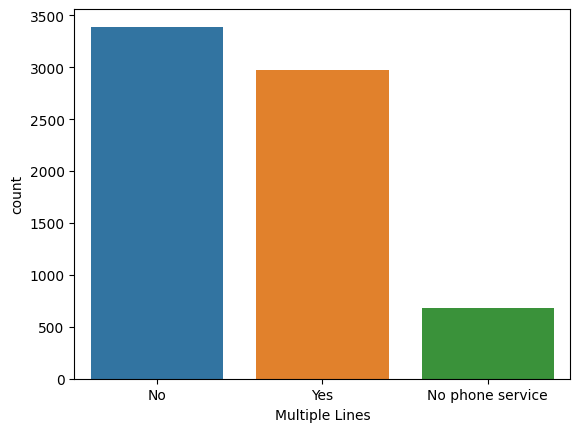

In [147]:
# Examine Multiple lines 
sns.countplot(x = "Multiple Lines", data = churn_df)

In [148]:
# Impact of multiple line on churn value
churn_df[['Multiple Lines', 'Churn Value']].groupby('Multiple Lines').mean().sort_values(by = 'Churn Value', ascending=False)

,Churn Value
Multiple Lines,
Yes,0.286099
No,0.250442
No phone service,0.249267


Customers with multipe lines connection have a higher churn rate. 

<Axes: xlabel='Internet Service', ylabel='count'>

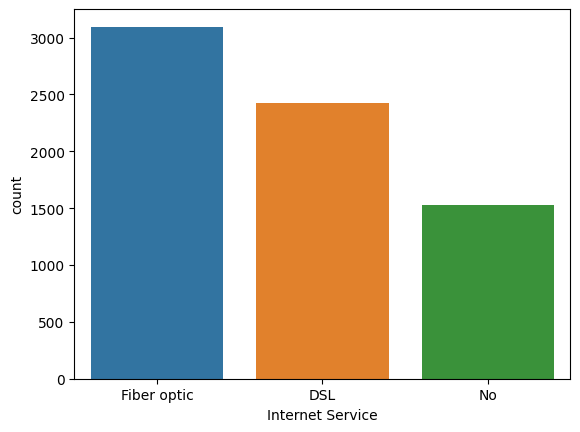

In [149]:
# Examine Internet Services
sns.countplot(x = "Internet Service", data = churn_df, 
              order = churn_df['Internet Service'].value_counts().index)

In [150]:
# Impact on churn value
churn_df[['Internet Service', 'Churn Value']].groupby('Internet Service').mean().sort_values(by= 'Churn Value', ascending = False)

,Churn Value
Internet Service,
Fiber optic,0.418928
DSL,0.189591
No,0.074050


People with Fiber Optic have a much higher churn rate.

### 1.6.1. Explore the Fiber Optic variable

In [151]:
churn_df[['Monthly Charges', 'Internet Service']].groupby('Internet Service').mean().sort_values(by = 'Monthly Charges')

,Monthly Charges
Internet Service,
No,21.079194
DSL,58.102169
Fiber optic,91.500129


The monthly charges for fiber optic connection is much higher than the other two.

### 1.6.2. Explore additional features

<Axes: xlabel='Streaming Movies', ylabel='count'>

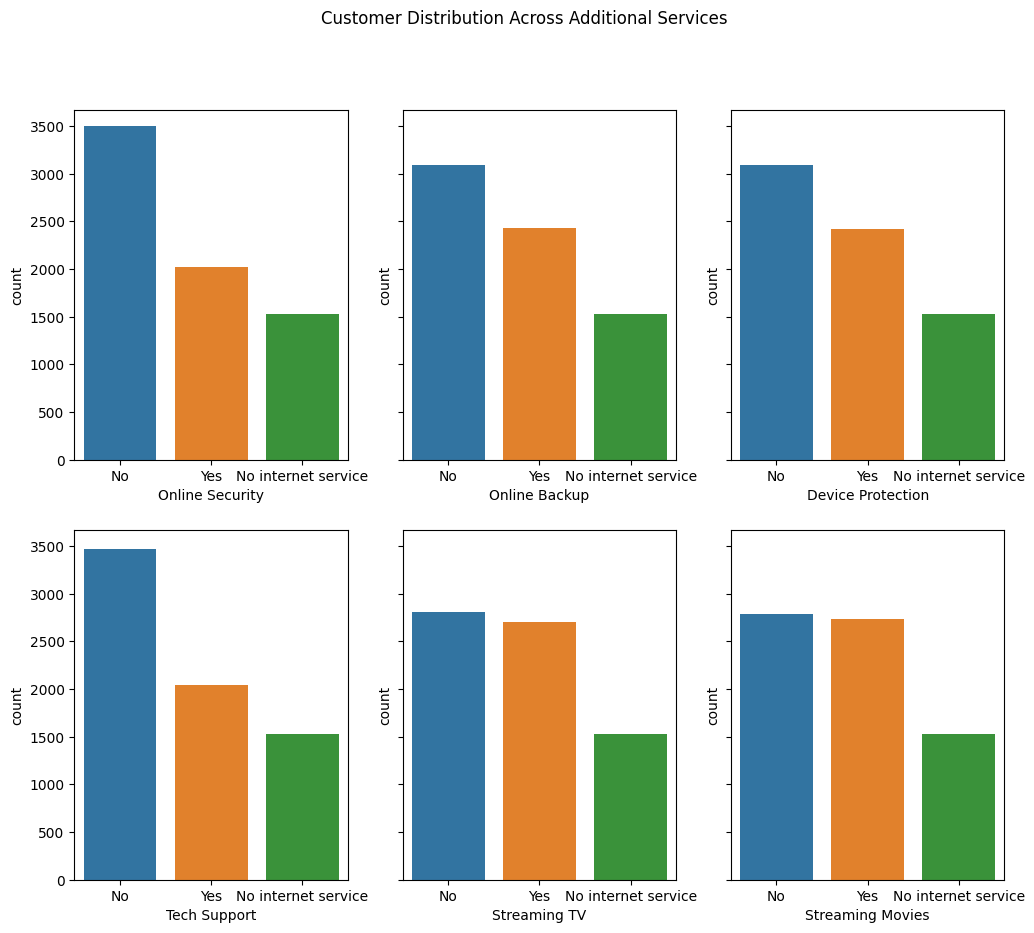

In [152]:
fig, axes = plt.subplots(2,3, figsize = (12,10), sharey = True)
plt.suptitle('Customer Distribution Across Additional Services')
sns.countplot(x='Online Security', data = churn_df, ax=axes[0,0], order = churn_df['Online Security'].value_counts().index)
sns.countplot(x='Online Backup', data = churn_df, ax=axes[0,1], order = churn_df['Online Backup'].value_counts().index)
sns.countplot(x='Device Protection', data = churn_df, ax=axes[0,2], order = churn_df['Device Protection'].value_counts().index)
sns.countplot(x='Tech Support', data = churn_df, ax=axes[1,0], order = churn_df['Tech Support'].value_counts().index)
sns.countplot(x='Streaming TV', data = churn_df, ax=axes[1,1], order = churn_df['Streaming TV'].value_counts().index)
sns.countplot(x='Streaming Movies', data = churn_df, ax=axes[1,2], order = churn_df['Streaming Movies'].value_counts().index)

Though these services are offered for free by the company, most people do not use them. Lets see if these feature impact the churn rate

In [153]:
churn_df[cat_cols].value_counts().count()

7043

### 1.6.3. Impact of internet related variables on churn rate

In [154]:
churn_df[['Online Security', 'Churn Value']].groupby('Online Security').mean().sort_values(by='Online Security')

,Churn Value
Online Security,
No,0.417667
No internet service,0.074050
Yes,0.146112


In [155]:
churn_df[['Device Protection', 'Churn Value']].groupby('Device Protection').mean().sort_values(by='Device Protection')

,Churn Value
Device Protection,
No,0.391276
No internet service,0.074050
Yes,0.225021


In [156]:
churn_df[['Online Backup', 'Churn Value']].groupby('Online Backup').mean().sort_values(by='Online Backup')

,Churn Value
Online Backup,
No,0.399288
No internet service,0.074050
Yes,0.215315


In [157]:
churn_df[['Tech Support', 'Churn Value']].groupby('Tech Support').mean().sort_values(by='Tech Support')

,Churn Value
Tech Support,
No,0.416355
No internet service,0.074050
Yes,0.151663


In [158]:
churn_df[['Streaming TV', 'Churn Value']].groupby('Streaming TV').mean().sort_values(by='Streaming TV')

,Churn Value
Streaming TV,
No,0.335231
No internet service,0.074050
Yes,0.300702


In [159]:
churn_df[['Streaming Movies', 'Churn Value']].groupby('Streaming Movies').mean().sort_values(by='Streaming Movies')

,Churn Value
Streaming Movies,
No,0.336804
No internet service,0.074050
Yes,0.299414


So the conclusion is people who don't opt for these internet services have a high churn rate. However, the churn rate difference between customers who use and do not use Streaming TV and Streaming Movies is quite low.

### 1.7. Exploring Contract and Payment Method

Text(0.5, 1.0, 'Customers by Contract Type')

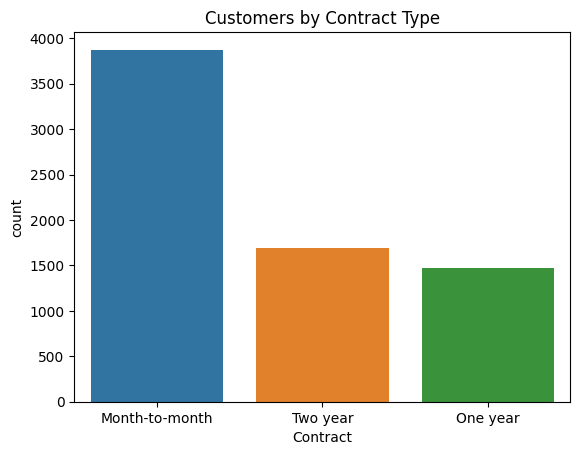

In [160]:
# Distribution of contract type
sns.countplot(x = 'Contract', data = churn_df)
plt.title('Customers by Contract Type')

In [161]:
# Impact of contract type on churn rate
churn_df[['Contract', 'Churn Value']].groupby('Contract').mean()

,Churn Value
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


No surprises here - Customers with shorter contract tend to churn more

Text(0.5, 1.0, 'Customers by Payment Method')

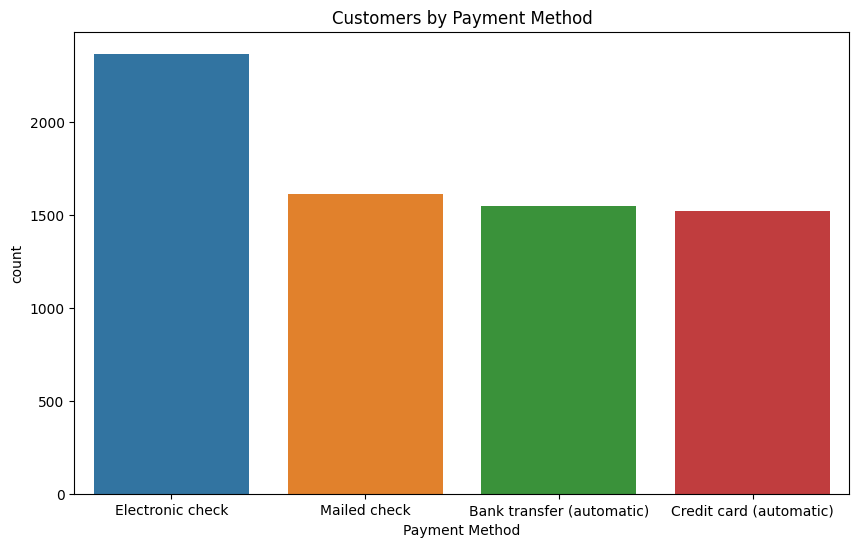

In [162]:
# Distribution of payment method 
plt.figure(figsize = (10,6))
sns.countplot(x = 'Payment Method', data = churn_df, order = churn_df['Payment Method'].value_counts().index)
plt.title('Customers by Payment Method')

In [163]:
# Imapct of payment method on churn rate
churn_df[['Payment Method', 'Churn Value']].groupby('Payment Method').mean().sort_values(by = 'Churn Value')

,Churn Value
Payment Method,
Credit card (automatic),0.152431
Bank transfer (automatic),0.167098
Mailed check,0.191067
Electronic check,0.452854


Here is something interesting, customers who pay electronic check are more likely to churn and also this payment method is most common among the costumers.

### 1.8 Exploring Continuous Feature

In [164]:
num_cols = []

for col in churn_df.columns:
    if churn_df[col].dtype.kind in 'iufc':
        num_cols.append(col)
num_cols

['Count',
 'Zip Code',
 'Latitude',
 'Longitude',
 'Tenure Months',
 'Monthly Charges',
 'Churn Value',
 'Churn Score',
 'CLTV']

### Here we have 4 numerical variables to deal with:

* Tenure Month - How long the customer has been with the company
* Monthly Charges 
* CLTV - Customer Lifetime Value
* Churn Score - The higher the score, the more likely the customer will churn

Note: We are ommiting Total Charges becasue its Tenure times Monthly Charges


Text(0.5, 1.0, 'Tenure vs Churn Value')

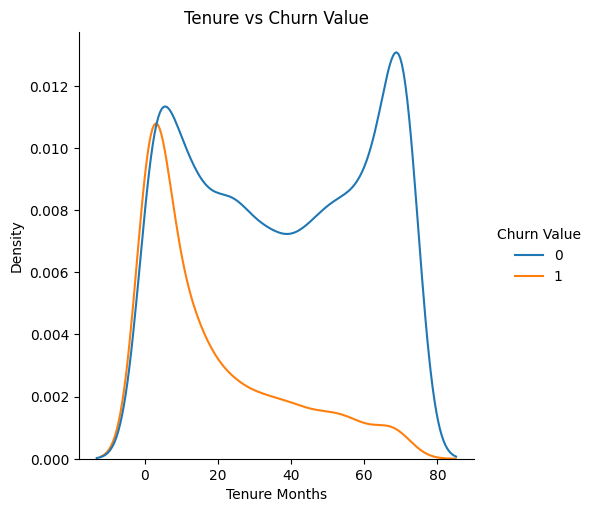

In [165]:
# Explporing Tenure
sns.displot(data = churn_df, x = "Tenure Months", hue = "Churn Value", kind = "kde")
plt.title('Tenure vs Churn Value')

Customers with lower tenure tend to churn more and vice-versa.

Text(0.5, 1.0, 'Monthly Charges vs Churn Value')

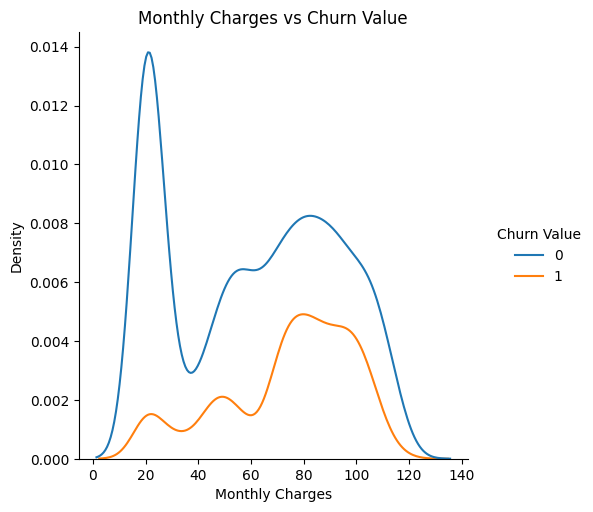

In [166]:
# Exploring Monthly Charges
sns.displot(data = churn_df, x= 'Monthly Charges', hue = 'Churn Value', kind = "kde")
plt.title('Monthly Charges vs Churn Value')

As the monthly charges go up customers tend to churn more.

In [167]:
churn_df[['Monthly Charges', 'Churn Value', 'Tenure Months']].groupby('Churn Value').mean()

,Monthly Charges,Tenure Months
Churn Value,,
0,61.265124,37.569965
1,74.441332,17.979133


Average monthly charges for churned customers is about 13 dollars higher and churned customers tend to leave the company about 20 months earlier than the not churned ones.

Text(0.5, 1.0, 'CLTV vs Churn Value')

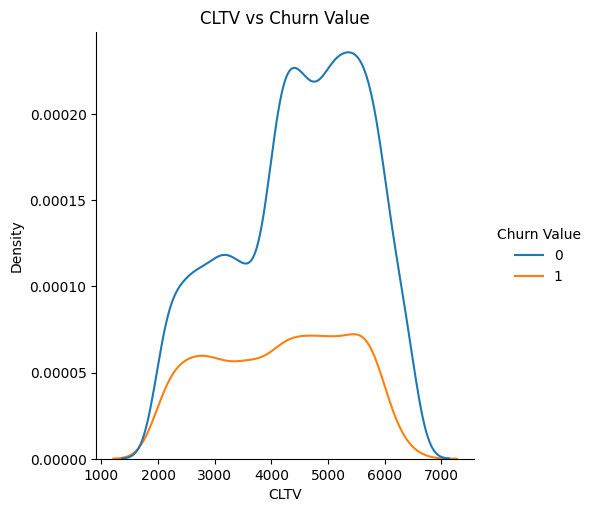

In [168]:
# Explore CLTV
sns.displot(data=churn_df, x='CLTV', hue='Churn Value', kind='kde')
plt.title('CLTV vs Churn Value')

In [169]:
churn_df[['CLTV', 'Churn Value']].groupby('Churn Value').mean()

,CLTV
Churn Value,
0,4490.921337
1,4149.414660


Text(0.5, 1.0, 'Churn Score vs Churn Value')

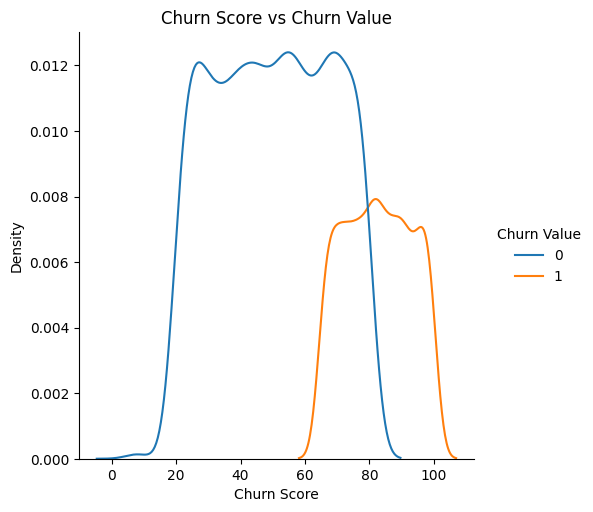

In [170]:
# Explore churn score
sns.displot(data=churn_df, x='Churn Score', hue='Churn Value', kind='kde')
plt.title('Churn Score vs Churn Value')

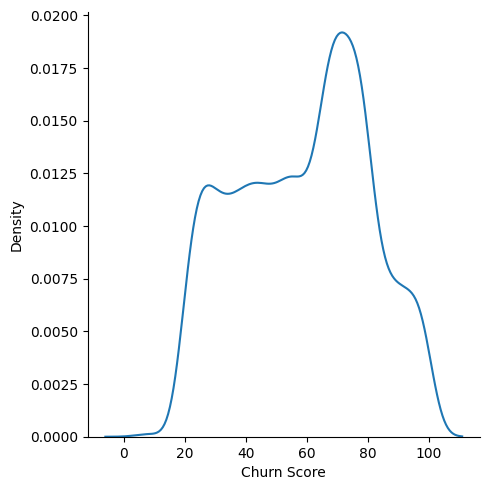

In [171]:
sns.displot(data=churn_df, x='Churn Score', kind= 'kde')

In [172]:
churn_df[['Churn Score', 'Churn Value']].groupby('Churn Value').mean()

,Churn Score
Churn Value,
0,50.098183
1,82.510433


From the EDA, I have further decided to drop the following cols as they do not impact the churn rate:
1. First 9 cols
2. Gender
3. Total Charges

In [173]:
# Filter features
filtered_df = churn_df.iloc[:, 9:]
filtered_df.drop(['Gender','Total Charges'], inplace = True, axis=1)
filtered_df.columns

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Value', 'Churn Score',
       'CLTV'],
      dtype='object')

# 2. Data Pre-processing 

### 2.1. Treating the imbalance in target variable

Text(0.5, 1.0, 'Distribution of Target Before Upsampling')

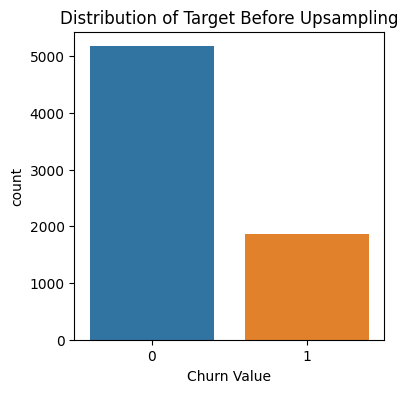

In [174]:
# Distribution of target variable before upsampling
plt.figure(figsize=(4,4))
sns.countplot(x = "Churn Value", data = churn_df)
plt.title('Distribution of Target Before Upsampling')

In [175]:
# Make two seperate dfs for churned and not churned
churned = filtered_df[filtered_df['Churn Value']==1]
not_churned = filtered_df[filtered_df['Churn Value'] == 0]

In [176]:
# Upsample the churned df
churned_upsampled = resample(churned, 
                             replace = True, 
                             n_samples = len(not_churned),
                             random_state = 1)

Text(0.5, 1.0, 'Distribution of Target After Upsampling')

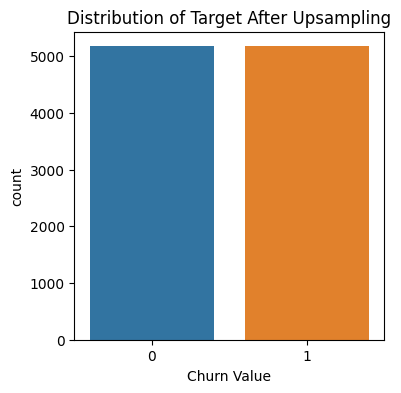

In [177]:
# Combining the upsampled data
plt.figure(figsize=(4,4))
combined_df = pd.concat([churned_upsampled, not_churned])
sns.countplot(x = "Churn Value", data = combined_df)
plt.title("Distribution of Target After Upsampling")

### 2.2. Seperate target from features

In [178]:
# Separate X and y
X = combined_df.drop(columns=['Churn Value'], axis= 1)
y = combined_df['Churn Value']
print("Shape of X:", X.shape)
print("Shape of y", y.shape)


Shape of X: (10348, 19)
Shape of y (10348,)


### 2.3. Data transformation

In [179]:
# Extract catagorical and numerical features from selected features 
cat_features = [i for i in filtered_df.columns if filtered_df[i].dtype == 'object']
num_cols = ['Tenure Months', 'Monthly Charges', 'CLTV',  'Churn Score']

# Define transformers 
# num_transformer = MinMaxScaler()
num_transformer = StandardScaler()
cat_transformers = OneHotEncoder()

# Define pipeline
preprocessor = ColumnTransformer(
    [
        ('Scaling', num_transformer, num_cols),
        ('OneHotEncoder', cat_transformers, cat_features)
    ]
)

In [180]:
# Transform the data
X= preprocessor.fit_transform(X)
X.shape

(10348, 45)

In [181]:
type(X)
type(y)

pandas.core.series.Series

In [182]:
# Train-test split
X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [183]:
X_trian.shape, X_test.shape, y_train.shape, y_test.shape

((8278, 45), (2070, 45), (8278,), (2070,))

# 3. Model Building and Model Selection

In [184]:
# Define model evaluation fn
def evaluate_model(true, predicted):
    accuracy = accuracy_score(true, predicted)
    recall = recall_score(true, predicted)
    precision = precision_score(true, predicted)
    return accuracy, recall, precision
    

In [185]:
# Define all the models to be evaluated
models={
    'AdaboostBoost' : AdaBoostClassifier(),
    'XGBClassifier' : XGBClassifier(random_state=1),
    'LogisticRegression' : LogisticRegression(),
    'svm' : svm.SVC(),
    'GradientBoosting' : GradientBoostingClassifier(),
    'RandomForest' : RandomForestClassifier(),
    'Naive Bayes' : GaussianNB(),
    'k-Nearest Neighbour' : KNeighborsClassifier()   
}

model_list = []
test_acc_list = []
train_acc_list = []
recall_list = []
precesion_list = []

In [186]:
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_trian, y_train)

    # Make prediction
    y_train_pred = model.predict(X_trian)
    y_test_pred = model.predict(X_test)

    # Get evaluation metrics
    train_acc, train_recall, train_precision = evaluate_model(true=y_train, predicted=y_train_pred)
    test_acc, test_recall, test_precision = evaluate_model(true=y_test, predicted=y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    # Print the results
    print('Model performance for Training set')
    print("- Accuracy Score: {:.4f}".format(train_acc))
    print("- Recall Score: {:.4f}".format(train_recall))
    print("- Precision Score: {:.4f}".format(train_precision))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy Score: {:.4f}".format(test_acc))
    print("- Recall Score: {:.4f}".format(test_recall))
    print("- Precision Score: {:.4f}".format(test_precision))
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)
    recall_list.append(test_recall)
    precesion_list.append(test_precision)
    
    print('='*35)
    print('\n')

AdaboostBoost
Model performance for Training set
- Accuracy Score: 0.9319
- Recall Score: 0.9479
- Precision Score: 0.9181
----------------------------------
Model performance for Test set
- Accuracy Score: 0.9304
- Recall Score: 0.9428
- Precision Score: 0.9217


XGBClassifier
Model performance for Training set
- Accuracy Score: 0.9981
- Recall Score: 1.0000
- Precision Score: 0.9961
----------------------------------
Model performance for Test set
- Accuracy Score: 0.9623
- Recall Score: 0.9847
- Precision Score: 0.9434


LogisticRegression
Model performance for Training set
- Accuracy Score: 0.9119
- Recall Score: 0.9239
- Precision Score: 0.9018
----------------------------------
Model performance for Test set
- Accuracy Score: 0.9101
- Recall Score: 0.9171
- Precision Score: 0.9067


svm
Model performance for Training set
- Accuracy Score: 0.9410
- Recall Score: 0.9704
- Precision Score: 0.9162
----------------------------------
Model performance for Test set
- Accuracy Score: 0.9

In [187]:
pd.DataFrame(list(zip(model_list, recall_list, test_acc_list, train_acc_list)), \
             columns=['Model Name', 'Recall Score', 'Test Acc Score', 'Train Acc Score'])\
                .sort_values(by=["Recall Score"],ascending=False).reset_index(drop=True)


,Model Name,Recall Score,Test Acc Score,Train Acc Score
0,RandomForest,0.991420,0.964734,1.000000
1,XGBClassifier,0.984747,0.962319,0.998067
2,GradientBoosting,0.954242,0.934300,0.943585
3,k-Nearest Neighbour,0.951382,0.886473,0.921599
4,AdaboostBoost,0.942803,0.930435,0.931868
5,svm,0.940896,0.922222,0.941049
6,LogisticRegression,0.917064,0.910145,0.911935
7,Naive Bayes,0.855100,0.804348,0.810461


### 3.1. Selected Models

* The task is to identify between Random Forest and XGB as they have the best recall and accuracy score. 
* In this use-case we don't want the costumers to churn (leave), so the apt model should have a higher recall score i.e. ability to predict true positives (avoid false negatives).
* Downside of aiming for higher recall is we sacrifice the precision i.e. model's ability to predict true positive or avoid false positive, so we end up giving better offers to few false postives as well, no major harm done - those costumers will tend to stick with us for a longer term. Business!!!!

# 4. Hyper-parameter tuning


In [188]:
# Define selected models
selected_models= {
    'Random Forest' : RandomForestClassifier(),
    'XGBClassifier' : XGBClassifier(random_state=1)
    }

In [189]:
# Set parameters for the selected models
params={
    'Random Forest': {
        # 'n_estimators': [10,50,100,150,200,300,500],
        'n_estimators' : [100],
        # 'criterion' : ['gini', 'entropy', 'log_loss'],
        # 'max_samples' : [500, 1000, 2000, 2500],
        'max_samples' : [2500],
        # 'max_depth':[5,10,15,20,25,50,100],
        'max_depth':[50]
    },

    'XGBClassifier': {
        # 'n_estimators':[10,50,100,150,200,300,500], 
        'n_estimators':[50], 
        # 'max_depth':[5,10,15,20,25,50,100], 
        'max_depth' : [20],
        # 'learning_rate': [0.1,0.2,0.3,0.4]
        'learning_rate': [0.3]
        
    }

}

### 4.1. Evaluating selected models

Fine Tuned Models
Random Forest
{'max_depth': 50, 'max_samples': 2500, 'n_estimators': 100}
Model performance for Training set
- Accuracy Score: 0.9752
- Recall Score: 0.9983
- Precision Score: 0.9541
----------------------------------
Model performance for Test set
- Accuracy Score: 0.9546
- Recall Score: 0.9886
- Precision Score: 0.9267




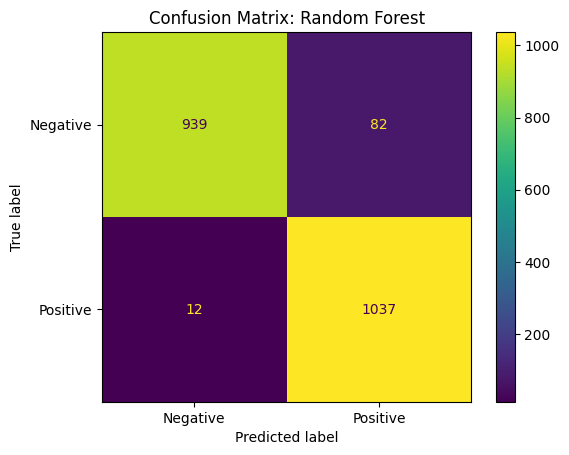

XGBClassifier
{'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 50}
Model performance for Training set
- Accuracy Score: 1.0000
- Recall Score: 1.0000
- Precision Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy Score: 0.9604
- Recall Score: 0.9838
- Precision Score: 0.9407




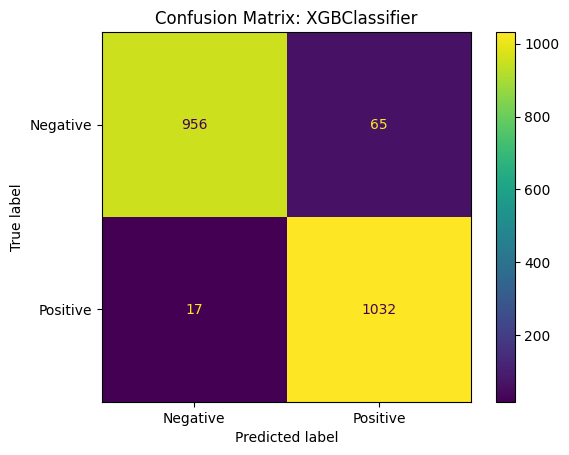

In [191]:
print("Fine Tuned Models")
for i in range(len(selected_models)):
    model = list(selected_models.values())[i]
    param=params[list(selected_models.keys())[i]]

    gs = GridSearchCV(model, param, cv=5)
    gs.fit(X_trian, y_train)

    print(list(selected_models.keys())[i])
    print(gs.best_params_)

    model.set_params(**gs.best_params_)
    model.fit(X_trian,y_train)

    # Make prediction
    y_train_pred = model.predict(X_trian)
    y_test_pred = model.predict(X_test)

    # Get evaluation metrics
    train_acc, train_recall, train_precision = evaluate_model(true=y_train, predicted=y_train_pred)
    test_acc, test_recall, test_precision = evaluate_model(true=y_test, predicted=y_test_pred)

    # Print the results
    print('Model performance for Training set')
    print("- Accuracy Score: {:.4f}".format(train_acc))
    print("- Recall Score: {:.4f}".format(train_recall))
    print("- Precision Score: {:.4f}".format(train_precision))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy Score: {:.4f}".format(test_acc))
    print("- Recall Score: {:.4f}".format(test_recall))
    print("- Precision Score: {:.4f}".format(test_precision))
    
    print('='*35)
    print('\n')

    # Confusion Matrix
    cm= confusion_matrix(y_test, y_test_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                                display_labels = ['Negative', 'Positive'])
    cm_display.plot()
    plt.title('Confusion Matrix: {}'.format(list(selected_models.keys())[i]))
    plt.show()

The XGB model is still overfitting after fine_tuning. Hence, I will stick with the RF model.

In [ ]:

# CM for fine-tuned RF model
confusion_matrix= confusion_matrix(y_test, test_pred_list[0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'])
cm_display.plot()
plt.title('Confusion Matrix: RandomForestClassifier')
plt.show()

# CM for fine-tuned XGB model
confusion_matrix= confusion_matrix(y_test, test_pred_list[1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'])
cm_display.plot()
plt.title('Confusion Matrix: XGBClassifier')
plt.show()


# 5. Conclusion

The XGB model looks to be overfitting even after tuning the parameters. So I choose to stick with the RandomForest model as it delivers a similar recall & accuracy score without overfitting. 